In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 图像金字塔

两类图像金字塔：高斯金字塔和拉普拉斯金字塔。
高斯金字塔的顶部是通过将底部图像中的连续的行和列去除得到的。顶部图像中的每一个像素值等于下一层图像中5哥像素的高斯加权平均值。这样操作一次一个MxN的图像就变成了一个M/2xN/2的图像。所以这幅图像的面积就变为原来图像面积的四分之一。这被称为Octave。连续进行这样操作我们就会得到一个分辨率不断下降的图像金字塔。OpenCV中可以使用cv2.pyrDown和cv2.pyrUp构建图像金字塔。函数cv2.pyrDown从一个高分辨率大尺寸的图像向上构建一个金字塔（尺寸变小，分辨率降低）。函数cv2.pyrUp从一个低分辨率小尺寸的图像向下构建一个金字塔（尺寸变大，分辨率**不会增加**）。

In [2]:
# cv2.pyrDown?

pyrDown(src[, dst[, dstsize[, borderType]]]) -> dst

In [3]:
def bgr_to_rgb(bgr):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb
def rgb_to_bgr(rgb):
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    return bgr

In [4]:
img_src_bgr = cv2.imread('../../data/lena.jpg')

In [5]:
img_dst_bgr = cv2.pyrDown(img_src_bgr)

In [6]:
img_dst_bgr.shape

(256, 256, 3)

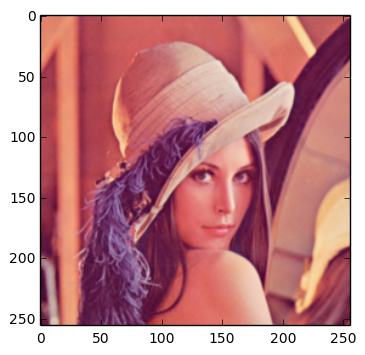

In [7]:
plt.imshow(bgr_to_rgb(img_dst_bgr))

In [8]:
img_dst_bgr = cv2.pyrUp(img_src_bgr)

In [9]:
img_dst_bgr.shape

(1024, 1024, 3)

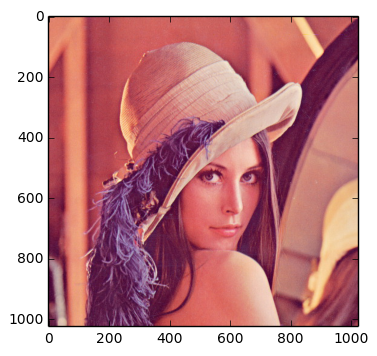

In [10]:
plt.imshow(bgr_to_rgb(img_dst_bgr))

拉普拉斯金字塔可以由高斯金字塔计算得到，公式如下：
$$L_i=G_i-PyrUp(G_{i+1})$$
拉普拉斯金字塔的图像看起来就像是图像的边界图，其中很多像素都是0，所以它们经常被用在图像压缩中，可以通过存储图像的拉普拉斯金字塔压缩图像。

## 使用金字塔进行图像融合
图像金字塔的一个应用就是图像融合，具体过程如下所示：
- 读入两幅图像I1和I2；
- 构建I1和I2的高斯金字塔；
- 根据高斯金字塔GP1和GP2计算拉普拉斯金字塔LP1和LP2；
- 在拉普拉斯的每一层进行图像融合；
- 根据融合后的图像金字塔重建原始图像。

In [11]:
I1 = cv2.imread('../../data/apple.jpg')

In [12]:
I2 = cv2.imread('../../data/orange.jpg')

In [13]:
I1.shape

(512, 512, 3)

In [14]:
I2.shape

(512, 512, 3)

In [15]:
GP_NUM = 6

In [16]:
# 构建I1和I2的高斯金字塔
G1 = I1.copy()
GP1 = [G1] # GP means Gaussian Pyramid
# 构建6层高斯金字塔
for p_layer in range(GP_NUM):
    G1 = cv2.pyrDown(G1)
    GP1.append(G1)
    
G2 = I2.copy()
GP2 = [G2] # GP means Gaussian Pyramid
# 构建6层高斯金字塔
for p_layer in range(GP_NUM):
    G2 = cv2.pyrDown(G2)
    GP2.append(G2)

In [17]:
# 根据高斯金字塔GP1和GP2计算拉普拉斯金字塔
LP1 = [GP1[GP_NUM-1]]
for p_layer in range(GP_NUM-1, 0, -1):
    GU1 = cv2.pyrUp(GP1[p_layer])
    L1 = cv2.subtract(GP1[p_layer-1], GU1)
    print('L1.shape:', L1.shape)
    LP1.append(L1)
    
LP2 = [GP2[GP_NUM-1]]
for p_layer in range(GP_NUM-1, 0, -1):
    GU2 = cv2.pyrUp(GP2[p_layer])
    L2 = cv2.subtract(GP2[p_layer-1], GU2)
    LP2.append(L2)

('L1.shape:', (32, 32, 3))
('L1.shape:', (64, 64, 3))
('L1.shape:', (128, 128, 3))
('L1.shape:', (256, 256, 3))
('L1.shape:', (512, 512, 3))


In [18]:
LP1[0].shape

(16, 16, 3)

In [19]:
# 在拉普拉斯的每层进行融合
blend_img_lps = []
for l1, l2 in zip(LP1, LP2):
    rows_1, cols_1, channel_1 = l1.shape
    rows_2, cols_2, channel_2 = l2.shape
#     print('cols_1:', cols_1)
#     print('cols_2:', cols_2)
    blend_img_l = np.hstack((l1[:, 0:cols_1/2], l2[:, cols_2/2:]))
#     print('blend_img_l.shape:', blend_img_l.shape)
    blend_img_lps.append(blend_img_l)
    

In [20]:
np.array(blend_img_lps[1]).shape

(32, 32, 3)

In [21]:
# 根据融合后的拉普拉斯金字塔重建图像
blend_img = blend_img_lps[0]
for p_layer in range(1, GP_NUM):
    blend_img = cv2.pyrUp(blend_img)
#     print('blend_img.shape:', blend_img.shape)
#     print('blend_img_lps[p_layer].shape:', blend_img_lps[p_layer].shape)
    blend_img = cv2.add(blend_img, blend_img_lps[p_layer])

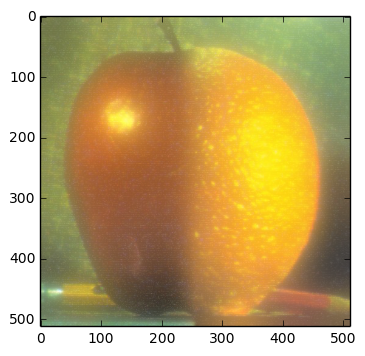

In [22]:
plt.imshow(bgr_to_rgb(blend_img))